In [1]:
! pip show numpy
! pip show scipy

Name: numpy
Version: 1.15.1
Summary: NumPy: array processing for numbers, strings, records, and objects.
Home-page: http://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages
Requires: 
Required-by: xgboost, tf-nightly-2.0-preview, tensorflowjs, tensorflow, tensorflow-hub, tensorboard, tb-nightly, statsmodels, scipy, patsy, pandas, opt-einsum, moviepy, matplotlib, Keras, Keras-Preprocessing, Keras-Applications, imageio, h5py, gensim
Name: scipy
Version: 1.3.1
Summary: SciPy: Scientific Library for Python
Home-page: https://www.scipy.org
Author: None
Author-email: None
License: BSD
Location: /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages
Requires: numpy
Required-by: xgboost, statsmodels, Keras, gensim


In [8]:
import numpy as np
import scipy
from scipy import optimize

def load_csv_to_ndarray(filepath):
    # Read using numpy lib and return all rows, no header in this case
    return np.genfromtxt(filepath, dtype=float, delimiter=',')

def transform_feature(one_dim_feature_vector):
    transformed_feature_vector = np.zeros((len(one_dim_feature_vector), 2*128))

    for i in range(0, len(one_dim_feature_vector)):
        feature = one_dim_feature_vector[i]
        transformed_feature = np.zeros(2*128)

        for j in range(0, 128):
            transformed_feature[2*j] = np.cos((j+1) * feature)

            transformed_feature[(2*j)+1] = np.sin((j+1) * feature)

        transformed_feature_vector[i] = transformed_feature

    return transformed_feature_vector

# Use np.linalg.lstsq to compute the minimum Euclidean norm solution
def compute_min_euclidean_norm_solution(feature_matrix, label_vector, use_pinv=False):
    if use_pinv:
        return np.dot(np.linalg.pinv(feature_matrix), label_vector)

    # Get X'
    feature_matrix_transposed = feature_matrix.T

    # Compute X'X (covariance matrix)
    feature_matrix_matmul = np.dot(feature_matrix_transposed, feature_matrix)

    # Basically, lstsq(M_1, M_2) will return a solution, let say M_sol
    # M_sol has the least squares or l2 norms amongst other solutions (there can also be no solution)
    # M_sol fulfills the equation: np.dot(M_1, M_sol) = M_2
    # In our case, M_1 would be X'X, M_2 would be X'y and M_sol would be the weights we seek
    return np.linalg.lstsq(feature_matrix_matmul, np.dot(feature_matrix_transposed, label_vector), rcond=None)[0]

def create_weights_diagonal_matrix(squared=False):
    weights = np.zeros(2*128)

    for j in range(0, 128):
        weights[2*j] = np.ceil((j+1)/2)
        if squared:
            weights[2*j] = weights[2*j] ** 2

        weights[(2*j)+1] = np.ceil((j+1)/2)
        if squared:
            weights[(2*j)+1] = weights[(2*j)+1] ** 2

    return weights, np.diag(weights)

def count_nonzero_entries(weights):
    count = 0

    for weight in weights:
        if abs(weight) < 1.e-15:
            count = count + 1

    return count

def run_experiment_1a(use_pinv=False):
    train_df = load_csv_to_ndarray('hw3p1_train.csv')
    test_df = load_csv_to_ndarray('hw3p1_test.csv')

    one_dim_feature_vector = train_df[:,0]
    label_vector = train_df[:,1]

    feature_matrix = transform_feature(one_dim_feature_vector)

    sol = compute_min_euclidean_norm_solution(feature_matrix, label_vector, use_pinv)

    test_feature_matrix = transform_feature(test_df)
    test_pred_result = np.dot(test_feature_matrix, sol)

    print('ERROR: ')
    print(np.dot(feature_matrix, sol) - label_vector)
    
    print(sol)

    print('Number of nonzero entries:')
    print(count_nonzero_entries(sol))

    # # By default, Mac OS X can't directly render matplotlib
    # # To use matplotlib, please use Jupyter Notebook or set the backend properly (https://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python)
    # import matplotlib.pyplot as plt
    #
    # fig = plt.figure(figsize=(10, 10))
    #
    # plt.title('Minimum Euclidean Plot')
    # plt.plot(test_df, test_pred_result, color='pink', linewidth=1, marker='o', markersize=3, mfc='white', mec='black')
    #
    # plt.savefig('1a.png', bbox_inches='tight')
    #
    # plt.show()

def run_experiment_1b(use_pinv=False):
    train_df = load_csv_to_ndarray('hw3p1_train.csv')
    test_df = load_csv_to_ndarray('hw3p1_test.csv')

    one_dim_feature_vector = train_df[:,0]
    label_vector = train_df[:,1]

    feature_matrix = transform_feature(one_dim_feature_vector)

    _, weights_diagonal_matrix = create_weights_diagonal_matrix()

    # Stack feature_matrix with weights_diagonal
    weighted_feature_matrix = np.vstack((feature_matrix, weights_diagonal_matrix))

    # Pad label_vector with zeros
    padded_label_vector = np.zeros(2*128 + len(label_vector))
    padded_label_vector[0:len(label_vector)] = label_vector

    sol = compute_min_euclidean_norm_solution(weighted_feature_matrix, padded_label_vector, use_pinv)

    test_feature_matrix = transform_feature(test_df)
    test_pred_result = np.dot(test_feature_matrix, sol)

    print('ERROR: ')
    print(np.dot(feature_matrix, sol) - label_vector)
    
    print(sol)

    print('Number of nonzero entries:')
    print(count_nonzero_entries(sol))

    # # By default, Mac OS X can't directly render matplotlib
    # # To use matplotlib, please use Jupyter Notebook or set the backend properly (https://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python)
    # import matplotlib.pyplot as plt
    #
    # fig = plt.figure(figsize=(10, 10))
    #
    # plt.title('Minimum Weighted Euclidean Plot')
    # plt.plot(test_df, test_pred_result, color='pink', linewidth=1, marker='o', markersize=3, mfc='white', mec='black')
    #
    # plt.savefig('1b.png', bbox_inches='tight')
    #
    # plt.show()

def run_experiment_1c():
    train_df = load_csv_to_ndarray('hw3p1_train.csv')
    test_df = load_csv_to_ndarray('hw3p1_test.csv')

    one_dim_feature_vector = train_df[:,0]
    label_vector = train_df[:,1]

    feature_matrix = transform_feature(one_dim_feature_vector)

    # 256
    weights, _ = create_weights_diagonal_matrix()

    # 512
    appended_weights = np.zeros(2*2*128)

    # First 256 is for w, last 256 for v
    # Give zero weights to w cause we don't give a shit about sum(w)
    # We care about sum(abs(w)), i.e. sum(v)
    appended_weights[2*128:2*2*128] = weights

    # Equality constraint

    # A^tA
    A_eq = np.dot(feature_matrix.transpose(), feature_matrix)
    # Add 256 more zero columns to fit for v
    A_eq = np.hstack((A_eq, np.zeros((2*128, 2*128))))
    print(A_eq.shape)
    # Label vector stay as is, A^tb will have shape 256
    b_eq = np.dot(feature_matrix.transpose(), label_vector)
    print(b_eq.shape)

    # Inequality constraint

    # Each pair of v and w needs to follow: - w - v <= 0 and w - v <= 0
    A_ub = np.zeros((512, 512))
    for i in range(0, int(len(A_ub)/2)):
        # -w_j - v_j
        A_ub[2*i][i] = -1
        A_ub[2*i][i+256] = -1

        # w_j - v_j
        A_ub[(2*i)+1][i] = 1
        A_ub[(2*i)+1][i+256] = -1

    # Upper bound <= 0
    b_ub = np.zeros(512)

    # No need to set bound for v, because the default is nonnegative
    # Set bound for w from -inf to inf (None, None)
    # Set bound for v from 0 to inf (0, None)
    bounds = []
    for i in range(0, 256):
        bounds.append((None, None))
    for i in range(0, 256):
        bounds.append((0, None))

    res = scipy.optimize.linprog(appended_weights, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='revised simplex')

    dantzig_sol = res.x[0:256]

    print('ERROR: ')
    print(np.dot(feature_matrix, dantzig_sol) - label_vector)

    print('Number of nonzero entries:')
    print(count_nonzero_entries(dantzig_sol))

    # # By default, Mac OS X can't directly render matplotlib
    # # To use matplotlib, please use Jupyter Notebook or set the backend properly (https://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python)
    # import matplotlib.pyplot as plt
    #
    # test_feature_matrix = transform_feature(test_df)
    # test_pred_result = np.dot(test_feature_matrix, dantzig_sol)
    #
    # fig = plt.figure(figsize=(10, 10))
    #
    # plt.title('Dantzig Selector Euclidean Plot')
    # plt.plot(test_df, test_pred_result, color='pink', linewidth=1, marker='o', markersize=3, mfc='white', mec='black')
    #
    # plt.savefig('1c.png', bbox_inches='tight')
    #
    # plt.show()

In [9]:
run_experiment_1a(False)

ERROR: 
[-2.02615702e-15 -3.55271368e-15  1.33226763e-15 -1.11022302e-16
 -2.33146835e-15  2.66453526e-15  5.55111512e-16 -6.10622664e-16
 -5.32907052e-15 -4.88498131e-15  5.32907052e-15  4.44089210e-16
 -1.05471187e-15  1.66533454e-16  4.44089210e-16 -1.11022302e-15
 -1.94289029e-15 -1.77635684e-15 -6.66133815e-16 -2.88657986e-15
  1.74860126e-15 -4.44089210e-16  1.37390099e-15 -2.22044605e-16
 -9.29811783e-16 -8.88178420e-16  1.31838984e-15 -1.11022302e-15
 -4.99600361e-16  6.66133815e-16  2.22044605e-16 -1.99840144e-15]
[ 0.04908832 -0.00718577 -0.03461254 -0.02689775 -0.03677315  0.02500117
  0.01177851  0.07089182 -0.01637569  0.00126613 -0.0481524  -0.0313346
 -0.03984917  0.00309323  0.04602581  0.02754584  0.0575453  -0.03482872
 -0.03664213 -0.00896763 -0.03017504 -0.04902317 -0.0915193  -0.01022128
  0.0530314   0.06122838 -0.01496866 -0.01259576  0.05112622  0.02575976
 -0.00897164 -0.0451098   0.00359347 -0.00092732 -0.02803674 -0.03264181
 -0.04183454  0.01711932  0.051388

In [10]:
run_experiment_1b()

ERROR: 
[-0.21446767 -1.0029611   1.3066666  -0.5565023  -0.19277294  0.48519983
  0.16357536  0.42608296 -1.00878131 -0.61722473  1.45082296 -1.18894001
  0.18868128  0.26110158 -0.20246542  0.23954608  0.27868055 -0.30719998
 -0.19715184 -0.26470466 -0.13239285  0.74827121 -0.14843482 -0.4722137
  0.33160853 -0.17317977 -0.10262321  0.27136428 -0.13801537  0.35423028
 -0.51149098  0.68714138]
[ 3.97231467e-01 -6.11491597e-02 -2.76521289e-01 -2.23012503e-01
 -2.40100394e-01  1.49642958e-01  8.51953060e-02  4.41236977e-01
 -8.74362568e-02  1.65825161e-03 -2.20392708e-01 -1.44330726e-01
 -1.50840162e-01  6.58364096e-03  1.72773522e-01  1.03967924e-01
  1.53347279e-01 -9.95585762e-02 -9.56325166e-02 -1.97741545e-02
 -6.61832926e-02 -1.06834310e-01 -1.86935714e-01 -1.61939283e-02
  8.35769146e-02  9.55506187e-02 -2.20939341e-02 -1.62793517e-02
  6.33624272e-02  2.91312106e-02 -1.06371317e-02 -5.27426462e-02
  2.87174001e-03 -4.81970628e-03 -2.73614508e-02 -2.81165908e-02
 -3.32478440e-02 

(256, 512)
(256,)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/_linprog_util.py:763: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning)


ERROR: 
[-9.92261828e-15 -1.37667655e-14 -1.02140518e-14 -1.23234756e-14
 -1.31561428e-14 -1.15463195e-14 -1.34336986e-14 -1.28230759e-14
 -1.33226763e-14 -1.37667655e-14 -1.24344979e-14 -1.37667655e-14
 -1.16018306e-14 -1.27120536e-14 -1.32949207e-14 -1.19904087e-14
 -1.27675648e-14 -1.17683641e-14 -1.27675648e-14 -1.38777878e-14
 -1.35585987e-14 -1.33226763e-14 -1.31838984e-14 -1.31006317e-14
 -1.32532874e-14 -1.22124533e-14 -1.17406085e-14 -1.28785871e-14
 -1.22124533e-14 -1.17683641e-14 -1.47659662e-14 -8.43769499e-15]


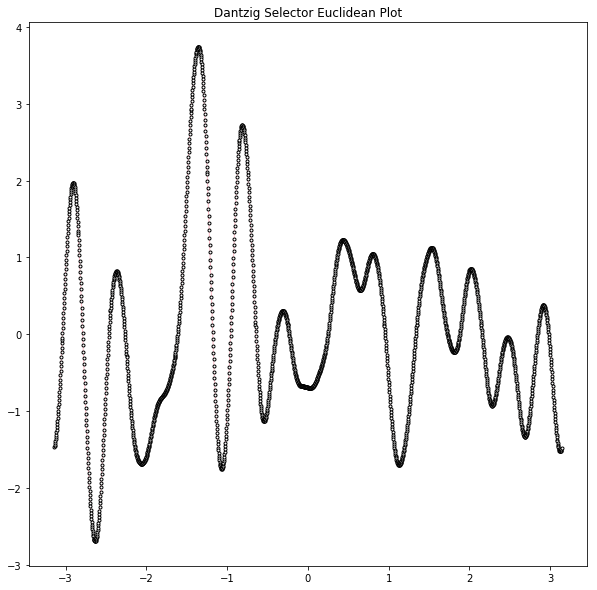

In [5]:
run_experiment_1c()

In [14]:
import numpy as np

train_df = load_csv_to_ndarray('hw3p1_train.csv')
test_df = load_csv_to_ndarray('hw3p1_test.csv')

one_dim_feature_vector = train_df[:,0]
label_vector = train_df[:,1]

feature_matrix = transform_feature(one_dim_feature_vector)
    
np.linalg.matrix_rank(feature_matrix)

32

In [19]:
simple_sol = np.dot(np.linalg.inv(np.dot(feature_matrix.transpose(), feature_matrix) + np.identity(256)), np.dot(feature_matrix.transpose(), label_vector))

In [20]:
simple_sol

array([ 0.04874669, -0.00713521, -0.03437277, -0.02670942, -0.03648349,
        0.0248028 ,  0.01168478,  0.07033452, -0.01624532,  0.00125532,
       -0.04777477, -0.0310872 , -0.03953353,  0.00306846,  0.04566131,
        0.02732904,  0.05709415, -0.03455439, -0.03635564, -0.00889714,
       -0.02993519, -0.04863674, -0.09080084, -0.01014127,  0.05261621,
        0.06074676, -0.0148533 , -0.01249749,  0.05072616,  0.02555808,
       -0.00890368, -0.04475589,  0.00356787, -0.00091837, -0.02781868,
       -0.03238666, -0.04150209,  0.01698669,  0.05098057,  0.08165111,
        0.02433845,  0.0175831 ,  0.02083749,  0.00870099,  0.01196351,
       -0.08577028, -0.03771627,  0.01270662,  0.03315041,  0.04604823,
        0.01466846,  0.03724452, -0.03123395, -0.00386438, -0.07356475,
        0.00489505,  0.02603896,  0.05885882,  0.00722802, -0.02382262,
        0.011518  , -0.02254156, -0.01273487, -0.02304905, -0.00873881,
       -0.02169924, -0.02222056,  0.05989986,  0.07447583,  0.00

In [21]:
np.dot(feature_matrix, simple_sol) - label_vector

array([ 0.00012387, -0.01104883,  0.02047247, -0.00305136,  0.00183661,
        0.0130771 ,  0.00699649,  0.00247518, -0.02256048, -0.01615112,
        0.01382025, -0.01928311, -0.00045617,  0.00415699, -0.00069533,
        0.00548697,  0.0038207 , -0.00725495, -0.00726007, -0.00722443,
       -0.0008603 ,  0.01338651, -0.00072527, -0.00857496,  0.00086095,
       -0.00393021, -0.00089551,  0.00525088,  0.00192606,  0.008057  ,
       -0.00310716,  0.01097686])

In [22]:
count_nonzero_entries(simple_sol)

0